Category 1 and 2 of the TF certification are:

1.   Basic Model
2.   Model from learning dataset

Whilst it is not entirely clear what the above means, Google cite the following [course](https://www.coursera.org/specializations/tensorflow-in-practice) for exam preparation.

This notebook covers the first 4 weeks of that course, leaving out minor details which are unlikely to be tested.

*Note: We are not aiming to get good results here, just demonstrate the basics of what will likely be tested.*

In [0]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
import numpy as np
import os
import zipfile
import random
import cv2

from scipy import misc

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tensorflow import keras as k
from tensorflow.keras import models
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

We begin with the most basic of networks, something which simply aims to model a linear function, such as the line y = 2x + 3.

In [0]:
# A single neuron
model = k.Sequential([
                      k.layers.Dense(units=1, input_shape=[1])
                      ])

In [0]:
model.compile(optimizer='sgd', loss='mean_squared_error')

In [0]:
# Quickly generate some training data
x = np.array([x for x in range(10)])

In [0]:
# Generate the corresponding outputs
y = np.array([2*x + 3 for x in range(10)])

In [6]:
model.fit(x,y, epochs=500, verbose=0) # verbosity just prevents cumbersome output

In [7]:
# Check model on a new number
print(model.predict([11]))

[[25.111576]]


Super easy! Now onto basic images, I imagine this is what "Model from a learning dataset" entails, using one of the built in TF datasets. Here we use the well known fashion mnist dataset from `tensorflow.keras.datasets`.

In [0]:
mnist = k.datasets.fashion_mnist

In [9]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [0]:
x_train = x_train / 255.0 # Normalize our data, each pixel is in range [0,255]
x_test = x_test / 255.0

In [0]:
# Simple fully connected network

model = k.models.Sequential([k.layers.Flatten(),  # Flatten since using Dense layers
                             k.layers.Dense(128, activation=tf.nn.relu),
                             k.layers.Dense(10, activation=tf.nn.softmax)])

In [0]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [13]:
model.fit(x_train, y_train, epochs=5, verbose=0)

In [14]:
model.evaluate(x_test, y_test)

10000/10000 [==============================] - 1s 65us/sample - loss: 0.3444 - accuracy: 0.8752


[0.3444185743331909, 0.8752]

Nice and simple. Now how about a callback to stop training once our accuracy has reached a desired value, say 80%...

In [0]:
class stopAt80(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.8): # If acc above 80%
      print("\nReached 80% accuracy so cancelling training!")
      self.model.stop_training = True # Stop training

In [0]:
callback = stopAt80()

In [0]:
model = k.models.Sequential([k.layers.Flatten(),
                             k.layers.Dense(128, activation=tf.nn.relu),
                             k.layers.Dense(10, activation=tf.nn.softmax)])

In [0]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [19]:
model.fit(x_train, y_train, epochs=10, callbacks=[callback])

Train on 60000 samples
Epoch 1/10
59712/60000 [============================>.] - ETA: 0s - loss: 0.4976 - accuracy: 0.8256
Reached 80% accuracy so cancelling training!
60000/60000 [==============================] - 5s 77us/sample - loss: 0.4969 - accuracy: 0.8259


Ezpz, now let us improve this with some basic convolutions.

In [0]:
# Reshaping from (x, 28, 28) -> (x, 28, 28, 1)
# Remember convolutions require 4D input, where last
# is the channel - mnist fashion is grayscale so 1

x_train_conv = x_train.reshape(x_train.shape+(1,))
x_test_conv = x_test.reshape(x_test.shape+(1,))

In [0]:
model = k.Sequential([
  k.layers.Conv2D(64, (3,3), activation='relu', input_shape=(28,28,1)),
  k.layers.MaxPooling2D(2,2),
  k.layers.Conv2D(64, (3,3), activation='relu'),
  k.layers.MaxPooling2D(2,2),
  k.layers.Flatten(),
  k.layers.Dense(128, activation='relu'),
  k.layers.Dense(10, activation='softmax')                      
])

In [0]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [34]:
model.fit(x_train_conv, y_train, epochs=5)

Train on 60000 samples
Epoch 1/5
60000/60000 [==============================] - 11s 188us/sample - loss: 0.4303 - accuracy: 0.8434
Epoch 2/5
60000/60000 [==============================] - 7s 110us/sample - loss: 0.2874 - accuracy: 0.8949
Epoch 3/5
60000/60000 [==============================] - 6s 108us/sample - loss: 0.2427 - accuracy: 0.9094
Epoch 4/5
60000/60000 [==============================] - 7s 109us/sample - loss: 0.2127 - accuracy: 0.9211
Epoch 5/5
60000/60000 [==============================] - 7s 109us/sample - loss: 0.1852 - accuracy: 0.9308


In [35]:
test_loss = model.evaluate(x_test_conv, y_test)

10000/10000 [==============================] - 1s 86us/sample - loss: 0.2559 - accuracy: 0.9106


The outline specifies needing to visualize an image moving through convolutions. Let us do that now.

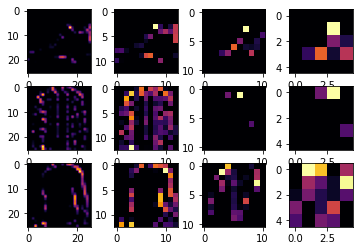

In [37]:
fig, ax = plt.subplots(3,4)

# Which images to visualize
FIRST_IMAGE=0
SECOND_IMAGE=7
THIRD_IMAGE=26
# Which feature channel to use
CONVOLUTION_NUMBER = 2
# Get layer outputs of existing model
layer_outputs = [layer.output for layer in model.layers]
# Build new model recieving the same input, but outputting the layers
activation_model = tf.keras.models.Model(inputs = model.input, outputs = layer_outputs)

for x in range(0,4):
  # Only first 4 correspond to conv/pooling layers
  # Get activations of first image
  f1 = activation_model.predict(x_test[FIRST_IMAGE].reshape(1, 28, 28, 1))[x]
  # Plot
  ax[0,x].imshow(f1[0, : , :, CONVOLUTION_NUMBER], cmap='inferno')
  ax[0,x].grid(False)
  # Second image
  f2 = activation_model.predict(x_test[SECOND_IMAGE].reshape(1, 28, 28, 1))[x]
  ax[1,x].imshow(f2[0, : , :, CONVOLUTION_NUMBER], cmap='inferno')
  ax[1,x].grid(False)
  # Third image
  f3 = activation_model.predict(x_test[THIRD_IMAGE].reshape(1, 28, 28, 1))[x]
  ax[2,x].imshow(f3[0, : , :, CONVOLUTION_NUMBER], cmap='inferno')
  ax[2,x].grid(False)

In the above, each row corresponds to an image, the columns correspond to the conv/maxpool/conv/maxpool layers respectively.

Whilst it is unlikely that we will be required to define our own convolutions and maxpooling, it is still cool to see how easy it can be done.

In [0]:
# Image with lots of edges
i = misc.ascent()

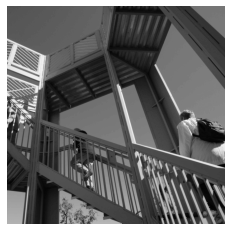

In [42]:
plt.grid(False)
plt.gray()
plt.axis('off')
plt.imshow(i)
plt.show()

In [0]:
i_filtered = np.copy(i) # Make copy
# x, y sizes of image
size_x = i_filtered.shape[0]
size_y = i_filtered.shape[1]

In [0]:
# Define our own filter
# Remember filter values should sum to 0 or 1

filter = [[1, 0, 0], 
          [0, -1, 0], 
          [0, 0, 1]]

# In case our filter does not add to 0 or 1
# i.e if they sum to 5, weight should equal .2
weight = 1  

In [0]:
for x in range(1,size_x-1):
   for y in range(1,size_y-1):
     # Convolve!
      conv = 0.0
      conv = conv + (i[x - 1, y-1] * filter[0][0])
      conv = conv + (i[x, y-1] * filter[0][1])
      conv = conv + (i[x + 1, y-1] * filter[0][2])
      conv = conv + (i[x-1, y] * filter[1][0])
      conv = conv + (i[x, y] * filter[1][1])
      conv = conv + (i[x+1, y] * filter[1][2])
      conv = conv + (i[x-1, y+1] * filter[2][0])
      conv = conv + (i[x, y+1] * filter[2][1])
      conv = conv + (i[x+1, y+1] * filter[2][2])
      conv = conv * weight
      # Cast out of range pixel values to min/max
      if(conv<0):
        conv=0
      if(conv>255):
        conv=255
      # Set pixels to convolution output
      i_filtered[x,y] = conv

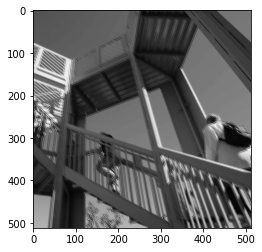

In [58]:
plt.gray()
plt.grid(False)
plt.imshow(i_filtered)
plt.show()   

What about our own max pooling?

In [0]:
# Max pooling will halve x, y shape
new_x = int(size_x/2)
new_y = int(size_y/2)

newImage = np.zeros((new_x, new_y))
for x in range(0, size_x, 2):
  for y in range(0, size_y, 2):
    pixels = []
    # Take 4 pixels
    pixels.append(i_filtered[x, y])
    pixels.append(i_filtered[x+1, y])
    pixels.append(i_filtered[x, y+1])
    pixels.append(i_filtered[x+1, y+1])
    # Take max of them
    newImage[int(x/2),int(y/2)] = max(pixels) 

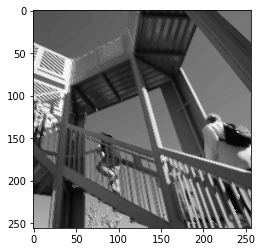

In [60]:
plt.gray()
plt.grid(False)
plt.imshow(newImage)
plt.show()      

Cool right? Now for the `ImageDataGenerator` API to have images flow from a local directory, and support for easy resizing.

In [61]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip \
    -O /tmp/horse-or-human.zip

--2020-03-17 08:47:15--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 216.58.193.208, 2607:f8b0:4007:802::2010
Connecting to storage.googleapis.com (storage.googleapis.com)|216.58.193.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149574867 (143M) [application/zip]
Saving to: ‘/tmp/horse-or-human.zip’

/tmp/horse-or-human 100%[===================>] 142.65M   166MB/s    in 0.9s    

2020-03-17 08:47:16 (166 MB/s) - ‘/tmp/horse-or-human.zip’ saved [149574867/149574867]



In [62]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip \
    -O /tmp/validation-horse-or-human.zip

--2020-03-17 08:47:21--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.11.80, 2607:f8b0:4007:801::2010
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.11.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11480187 (11M) [application/zip]
Saving to: ‘/tmp/validation-horse-or-human.zip’

/tmp/validation-hor 100%[===================>]  10.95M  --.-KB/s    in 0.08s   

2020-03-17 08:47:22 (146 MB/s) - ‘/tmp/validation-horse-or-human.zip’ saved [11480187/11480187]



In [0]:
local_zip = '/tmp/horse-or-human.zip' # File location
zip_ref = zipfile.ZipFile(local_zip, 'r') # Read
zip_ref.extractall('/tmp/horse-or-human') # Extract into directory
local_zip = '/tmp/validation-horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/validation-horse-or-human')
zip_ref.close()

In [0]:
# Image directories

train_horse_dir = os.path.join('/tmp/horse-or-human/horses')
train_human_dir = os.path.join('/tmp/horse-or-human/humans')

validation_horse_dir = os.path.join('/tmp/validation-horse-or-human/horses')
validation_human_dir = os.path.join('/tmp/validation-horse-or-human/humans')

# List images - for visualization later
train_horse_names = os.listdir(train_horse_dir)
train_human_names = os.listdir(train_human_dir)


In [0]:
model = tf.keras.models.Sequential([
    # Channel dimension is 3, since these images are RGB
    k.layers.Conv2D(16, (3,3), activation='relu', input_shape=(300, 300, 3)),
    k.layers.MaxPooling2D(2, 2),
    k.layers.Conv2D(32, (3,3), activation='relu'),
    k.layers.MaxPooling2D(2,2),
    k.layers.Conv2D(64, (3,3), activation='relu'),
    k.layers.MaxPooling2D(2,2),
    k.layers.Conv2D(64, (3,3), activation='relu'),
    k.layers.MaxPooling2D(2,2),
    k.layers.Conv2D(64, (3,3), activation='relu'),
    k.layers.MaxPooling2D(2,2),
    k.layers.Flatten(),
    k.layers.Dense(512, activation='relu'),
    k.layers.Dense(1, activation='sigmoid')
])

In [0]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [0]:
# Initialize image generators, note we can normalize here
train_datagen = ImageDataGenerator(rescale=1/255) # Normalize
val_datagen = ImageDataGenerator(rescale=1/255)

In [78]:
train_gen = train_datagen.flow_from_directory(
    '/tmp/horse-or-human/',  # Should be the directory containing our sub folders
    target_size=(300,300),   # Easy resizing on the fly
    batch_size=128,
    class_mode='binary'
)

val_gen = val_datagen.flow_from_directory(
    '/tmp/validation-horse-or-human/',
    target_size=(300,300),
    batch_size=32,
    class_mode='binary'
)

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


In [79]:
history = model.fit(  # fit_generator is deprecated, fit now supports generators
      train_gen,
      steps_per_epoch=8,  
      epochs=5,
      verbose=1,
      validation_data = val_gen,  # performs validation after each epoch
      validation_steps=8)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 8 steps, validate for 8 steps
Epoch 1/5
8/8 [==============================] - 8s 1s/step - loss: 0.7049 - acc: 0.5095 - val_loss: 0.6758 - val_acc: 0.8281
Epoch 2/5
8/8 [==============================] - 7s 931ms/step - loss: 0.6591 - acc: 0.6997 - val_loss: 0.5518 - val_acc: 0.6758
Epoch 3/5
8/8 [==============================] - 7s 928ms/step - loss: 0.4351 - acc: 0.7953 - val_loss: 1.0694 - val_acc: 0.7031
Epoch 4/5
8/8 [==============================] - 7s 929ms/step - loss: 0.1850 - acc: 0.9232 - val_loss: 1.8012 - val_acc: 0.7812
Epoch 5/5
8/8 [==============================] - 8s 944ms/step - loss: 0.0843 - acc: 0.9677 - val_loss: 1.9094 - val_acc: 0.7891


To end off, a complete visualisation of the complete outputs for all conv/pool layers is seen below.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


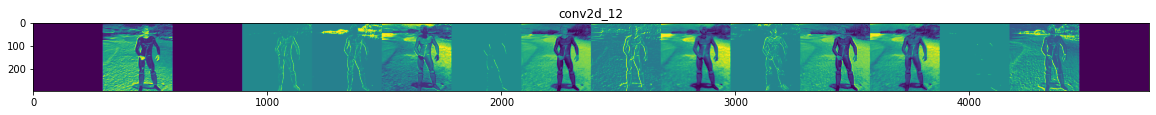

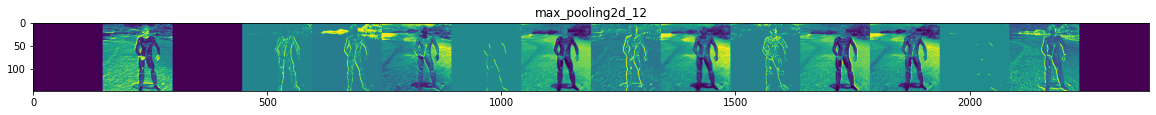

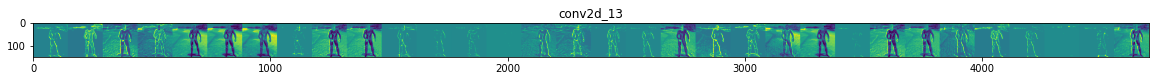

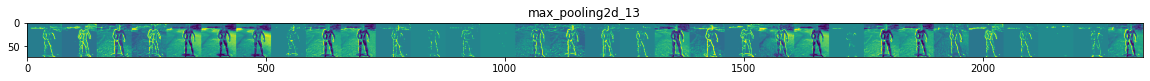

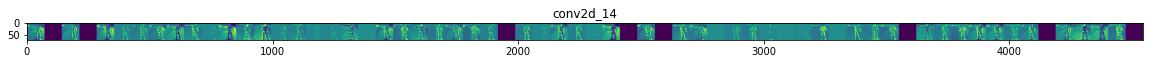

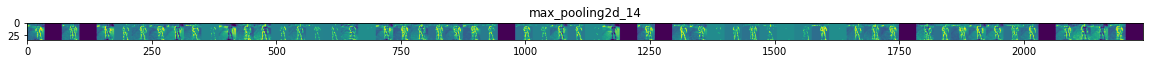

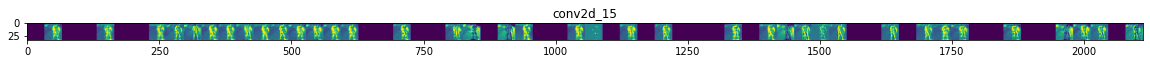

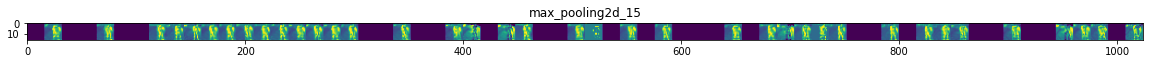

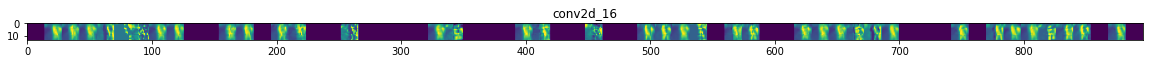

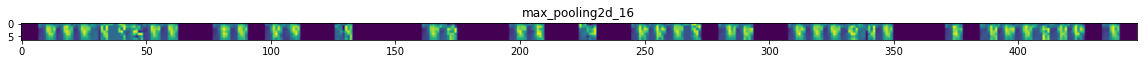

In [83]:
# Define a model to visualize the output of all layers
successive_outputs = [layer.output for layer in model.layers]
visualization_model = tf.keras.models.Model(inputs = model.input, 
                                            outputs = successive_outputs)

# Take random image from data to visualize
horse_img_files = [os.path.join(train_horse_dir, f) for f in train_horse_names]
human_img_files = [os.path.join(train_human_dir, f) for f in train_human_names]
img_path = random.choice(horse_img_files + human_img_files)

img = load_img(img_path, target_size=(300, 300))
x = img_to_array(img)  # Numpy array with shape (300, 300, 3)
# Remember to add the batch dimension for passing to conv layer
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 300, 300, 3)

x /= 255  # Normalize

# Get feature maps
successive_feature_maps = visualization_model.predict(x)

# Get layer names
layer_names = [layer.name for layer in model.layers]

# Zip features of a layer with it's name
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:
    # Only display conv/pool maps
    n_features = feature_map.shape[-1]  # number of channels/features
    size = feature_map.shape[1] # Size of image
    # Tile image in matrix
    display_grid = np.zeros((size, size * n_features))  # grid for each feature 
    for i in range(n_features):
      # Postprocess -  without this images are tough to see 
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
      # Tile current feature
      display_grid[:, i * size : (i + 1) * size] = x
    # Display the grid
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

Notice the sparsity as we get deeper into the network? This is one of strengths of deep convolution models, sparse representations!